In [1]:
import torch
import wandb

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from tennis_court_tracker.data.TennisCourtDataset import TennisCourtDataset, Rescale, ToTensor
from tennis_court_tracker.models.model import TrackNet

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

tensor(4.5525, device='mps:0', grad_fn=<NllLoss2DBackward0>)


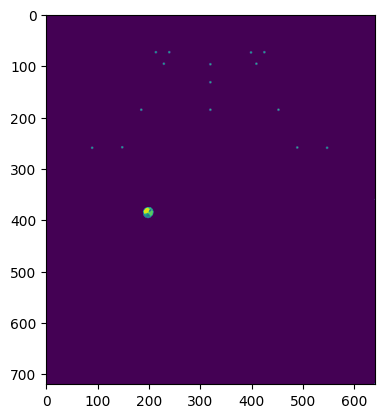

TypeError: Input type int64 is not supported

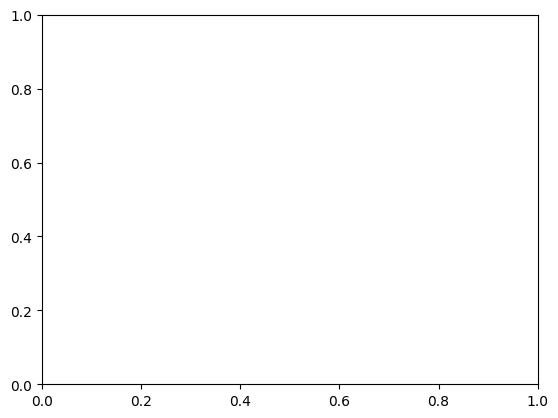

In [17]:
# Load model
device = 'mps'

model_path = "../final_model.pt"
model = TrackNet(in_features = 3)
model.load_state_dict(torch.load(model_path))
model.to(device)

dataset = TennisCourtDataset(
    "../data/processed/keypoints.csv", 
    "../data/processed/images",
    "../data/processed/labels",
    transform = transforms.Compose([
        Rescale((360, 640)),
        ToTensor(device)
    ])
)
n = 10
dataset_subset = torch.utils.data.Subset(dataset, range(n))
dataloader = DataLoader(dataset_subset, batch_size=1, shuffle=False, num_workers=0)

model.eval()
loss_fn = torch.nn.CrossEntropyLoss()

# images = [batch['image'] for batch in dataloader]
# labels = [batch['label'] for batch in dataloader]

for batch_num, batch in enumerate(dataloader):
    x = batch['image']
    y = batch['label']

    y_pred = model(x) # shape: [batch_size, 1, 360, 640]

    loss = loss_fn(y_pred, y)
    print(loss)
    
    grid = make_grid([y.squeeze(), y_pred.squeeze().argmax(dim=0)])
    show(grid)

    # im_true = y.squeeze().cpu().numpy()
    # im_pred = y_pred.squeeze().argmax(dim=0).cpu().numpy()
    # plt.imshow(im_true)
    # plt.show()

    break


In [35]:
print(labels[0].shape, predictions[0].shape)

torch.Size([1, 360, 640]) torch.Size([255, 360, 640])


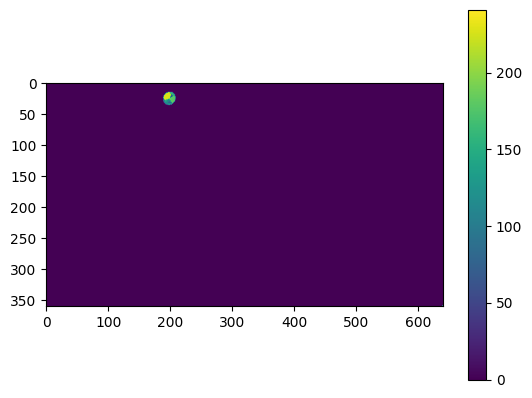

In [43]:
plt.imshow(predictions[0].argmax(dim=0).squeeze().detach().numpy())
# plt.imshow(predictions[0,1].squeeze().detach().numpy())
plt.colorbar()
plt.show()

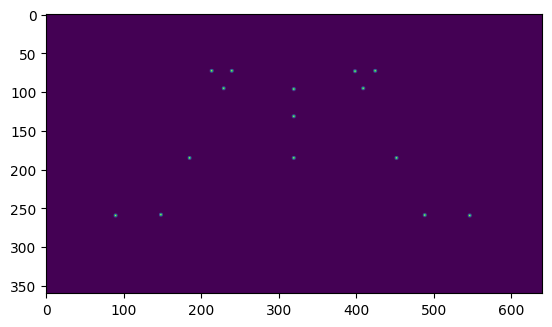

In [14]:
plt.imshow(labels[0].squeeze().detach().numpy())
plt.show()

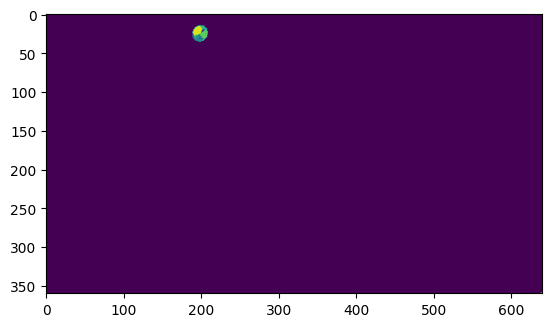

In [9]:
plt.imshow(predictions[1].squeeze().argmax(dim=0).detach().numpy())
plt.show()